# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## April 02, 2020

## Overview

This notebook contains the TensorFlow model training and prediction used to segment trees for [Restoration Mapper](https://restorationmapper.org). The notebook uses tensorflow 1.13.1 and additionally relies on Keras and tflearn. 

## Table of Contents

- Package loading
- Utility scripts
- Hyperparameter definitions
- Custom tensorflow layer functions
- Tensorflow graph creation
- Data loading
- Data preprocessing
- Equibatch creation
- Loss definition
- Tensorflow graph initialization
- Training
- Model validation
- Sanity Checks

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Utility scripts

In [2]:
%run ../../src/layers/zoneout.py
%run ../../src/layers/convgru.py
%run ../../src/layers/adabound.py
%run ../../src/layers/dropblock.py
%run ../../src/layers/extra_layers.py
%run ../../src/preprocessing/indices.py
%run ../../src/preprocessing/slope.py
%run ../../src/utils/metrics.py
%run ../../src/not_for_release/lovasz.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.20 #0.2 for master model
GRU_FILTERS = 32
FPA_FILTERS = 28
OUT_FILTERS = 32
AVERAGE_GRU_FILTERS = True
ACTIVATION_FUNCTION = 'relu'

INITIAL_LR = 1e-4
FINAL_LR = 2e-2
DROPBLOCK_MAXSIZE = 5
DECONV = 'bilinear'
N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.7
LABEL_SMOOTHING = 0.10 #0.075 for master
BATCH_RENORM = 'norm'

L2_REG = 0.0
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
MAX_DROPBLOCK = 0.85

gru_flt = 32
fpa_flt = 32
out_conv_flt = 32

IMAGE_SIZE = 16
LABEL_SIZE = 14

# Hyperparameter grid search definitions

In [4]:
# There are 3.8 million combinations of hyperparameters
params = {
    'zone_out' : [0],#range(0, 0.5, 0.1), #6
    'gru_filters': [0], #range(16, 64, 8), #6
    'fpa_filters': [0], #range(24, 48, 4), # 6
    'out_conv_filter': range(16, 64, 16), # 5
    'average_gru_filters': [True, False], # 2
    'activation_function': ['relu', 'selu', 'elu'], # relu > elu ? selu
    'final_lr': [5e-3, 1e-2, 2e-2, 5e-2], # 4
    'dropblock_maxsize': [7, 6, 5, 4, 3], # 5
    'deconv': ['bilinear', 'convtranspose2d'], # 2
    'n_conv_blocks': [3, 2, 1], # 3
    'final_alpha': [0.8, 0.75, 0.7, 0.65, 0.6], #5
    'label_smoothing': [0., 0.025, 0.05, 0.075, 0.10, 0.125],
    'batch_renorm': ['renorm', 'norm']
}

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [5]:
def Batch_Normalization(x, training, scope, clipping_params):
    '''Batch renormalization layer from tensorflow.layers

         Parameters:
          x (tf.Variable): input layer
          training (tf.Variable): flag to differentiate between train/test ops
          scope (str): tensorflow scope
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): output of batch renormalization
          
         References:
          https://github.com/tensorflow/docs/blob/r1.13/site/en/
          api_docs/python/tf/layers/batch_normalization.md
    '''
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               renorm_clipping = clipping_params,
                               name = scope)


def calc_renorm_params(epoch, n_samples, batch_size, k = 0):
    '''Calculates the clipping parameters for renormalization
       based on the learning schedule outlined in the original paper
       where rmax is initialized to 1, dmax to 0, rmin to 0,
       (effectively batch normalization), and then rmax and dmax
       are gradually reaxed to 3 and 5 over 40k and 25k steps,
       respectively. In this case, 40k has been reduced to 30k, and 25k
       has been reduced to 20k.

         Parameters:
          epoch (int): number of current training epoch
                       if testing, epoch number of model used
          n_samples (int): total number of training samples
          batch_size (int): training batch size 

         Returns:
          rmax (float)
          dmax (float)
          rmin (float)
    '''
    step = epoch * (n_samples // batch_size)
    step += k
    if step < 2500:
        rmax = 1.
        dmax = 0.
        rmin = 0.
    if step >= 2500:
        rmax = np.min([1 + 2*((step-2500)/20000), 3])
        dmax = np.min([1 + 5*((step-2500)/15000), 5])
        rmin = 0.
    return rmax, dmax, rmin

def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [6]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps

### Conv blocks

In [7]:
def conv_selu(inp, is_training, kernel_size, scope,
                filter_count = 16, pad = True, padding = 'valid', dilated = False,
                activation = True):
    '''Convolutional 2D layer with SELU activation and Lecun normal initialization
       with no batch norm. Only used if params['activation'] = 'selu'

         Parameters:
          inp (tf.Variable): (B, H, W, C) input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): kernel size of convolution
          scope (str): tensorflow variable scope
          filter_count (int): number of convolution filters
          pad (bool): whether or not to reflect pad input
          padding (str): one of ['valid', 'same']
          dilated (bool): whether to perform atruous convolution
          activation (bool): whether to activate output

         Returns:
          conv (tf.Variable): output of Conv2D -> SELU
          
         References:
          https://arxiv.org/abs/1706.02515
    '''
    if activation:
        act = selu
    else:
        act = None
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = act, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def conv_bn_relu(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 clipping_params,
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 batch_norm = True,
                 dropblock = True,
                 csse = True):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    bn_flag = "Batch Renorm" if batch_norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    
    print("{} {} Conv 2D {} {} {} {} {}".format(scope, kernel_size,
                                                   bn_flag, activation_flag,
                                                   csse_flag, bias_flag, drop_flag))
    
    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if batch_norm:
        conv = Batch_Normalization(conv, is_training, scope, clipping_params)
    if activation:
        conv = tf.nn.relu(conv)
    if csse:
        conv = csse_block(conv, 'csse_' + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
            conv = drop_block(conv, is_training)
    return conv


def create_deconv_init(filter_size, num_channels):
    '''Initializes a kernel weight matrix with a bilinear deconvolution
    
         Parameters:
          filter_size (int): kernel size of convolution
          num_channels (int): number of filters for convolution

         Returns:
          bilinear_init (tf.Variable): [filter_size, filter_size, num_channels] kernel
    '''
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init

def get_deconv2d(inp, filter_count, num_channels, scope, is_training, clipping_params):
    '''Creates a deconvolution layer with Conv2DTranspose. Following recent
       recommendations to use 4 kernel, 2 stride to avoid artifacts. 
       Initialize kernel with bilinear upsampling.

         Parameters:
          inp (tf.Variable): input tensorflow layer (B, X, Y, C) shape
          filter_count (int): number of filters for convolution
          num_channels (int): number of output channels
          scope (str): tensorflow variable scope
          is_training (str): flag to differentiate between train/test ops
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): layer with (B, x * 2, y * 2, C) shape
          
         References:
          https://distill.pub/2016/deconv-checkerboard/
    '''
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        use_bias = False,
                                        kernel_initializer = bilinear_init)(inp)
    #x = ELU()(x)
    #x = tf.nn.relu(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn", clipping_params = clipping_params)
    return x
    
def fpa(inp, is_training, filter_count, clipping_params, 
        keep_rate, upsample = "upconv"):
    '''Feature pyramid attention layer block, that allows for cross-scale combination
       of different size features without making blurry feature maps.

         Parameters:
          inp (tf.Variable): input tensorflow layer
          is_training (str): flag to differentiate between train/test ops
          filter_count (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          concat_1 (tf.Variable): output of FPA
          
         References:
          https://arxiv.org/abs/1805.10180
    '''
    one = conv_bn_relu(inp = inp, is_training = is_training, 
                       kernel_size = 1, scope =  'forward1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True,
                       dropblock = False,
                       csse = False)
    
    seven = conv_bn_relu(inp = inp_pad, is_training = is_training, 
                       kernel_size = 7, scope =  'down1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    seven_f = conv_bn_relu(inp = seven, is_training = is_training, 
                       kernel_size = 7, scope =  'down1_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    five = conv_bn_relu(inp = seven, is_training = is_training, 
                       kernel_size = 5, scope =  'down2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    five_f = conv_bn_relu(inp = five, is_training = is_training, 
                       kernel_size = 5, scope =  'down2_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    three = conv_bn_relu(inp = five, is_training = is_training, 
                       kernel_size = 3, scope =  'down3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    three_f = conv_bn_relu(inp = three, is_training = is_training, 
                       kernel_size = 3, scope =  'down3_f', stride = (2, 2),
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
        
    
    if upsample == 'upconv' or 'bilinear':
        three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_f)
        if upsample == 'upconv':
            three_up = ReflectionPadding2D((1, 1,))(three_up)
            three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True,
                       csse = False, dropblock = False)
            
            # 4x4
            three_up = tf.nn.relu(tf.add(three_up, five_f))
            
    
    if upsample == 'upconv' or "bilinear":
        five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_up)
        if upsample == 'upconv':
            five_up = ReflectionPadding2D((1, 1,))(five_up)
            five_up = conv_bn_relu(inp = five_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            five_up = tf.nn.relu(tf.add(five_up, seven_f))
            
    if upsample == 'upconv' or "bilinear":
        seven_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(five_up)
        if upsample == 'upconv':
            seven_up = ReflectionPadding2D((1, 1,))(seven_up)
            seven_up = conv_bn_relu(inp = seven_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            
            
            

    
    print("One: {}".format(one.shape))
    print("Seven: {}".format(seven.shape))
    print("Seven f: {}".format(seven_f.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    print("Seven_up: {}".format(seven_up.shape))
    
    # top block

    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_relu(inp = tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                       is_training = is_training, 
    #                   kernel_size = 1, scope =  'topconv',
    #                   filters = filter_count, clipping_params = clipping_params,
    #                   keep_rate = keep_rate, activation = False,
    #                   use_bias = False, batch_norm = True, 
    #                   csse = False, dropblock = False)
    #one_top = conv_bn_relu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    ##                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    
    seven_up = tf.multiply(one, seven_up)
    out = tf.nn.relu(seven_up + four_top)
    return out


In [8]:
def fpa(inp, is_training, filter_count, clipping_params, 
        keep_rate, upsample = "upconv"):
    '''Feature pyramid attention layer block, that allows for cross-scale combination
       of different size features without making blurry feature maps.

         Parameters:
          inp (tf.Variable): input tensorflow layer
          is_training (str): flag to differentiate between train/test ops
          filter_count (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          concat_1 (tf.Variable): output of FPA
          
         References:
          https://arxiv.org/abs/1805.10180
    '''
    one = conv_bn_relu(inp = inp, is_training = is_training, 
                       kernel_size = 1, scope =  'forward1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True,
                       dropblock = False,
                       csse = False)
    inp_pad = ReflectionPadding2D(padding = (2, 2))(inp)
    seven = conv_bn_relu(inp = inp_pad, is_training = is_training, 
                       kernel_size = 5, scope =  'down1', stride = (2, 2),
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    seven_pad = ReflectionPadding2D(padding = (2, 2))(seven)
    seven_f = conv_bn_relu(inp = seven_pad, is_training = is_training, 
                       kernel_size = 5, scope =  'down1_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    print("Seven: {}".format(seven.shape))
    print("Seven f: {}".format(seven_f.shape))
    
    five_pad = ReflectionPadding2D(padding = (1, 1))(seven)
    five = conv_bn_relu(inp = five_pad, is_training = is_training,  stride = (2, 2),
                       kernel_size = 3, scope =  'down2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    five_pad2 = ReflectionPadding2D(padding = (1, 1))(five)
    five_f = conv_bn_relu(inp = five_pad2, is_training = is_training, 
                       kernel_size = 3, scope =  'down2_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    '''
    three_pad = ReflectionPadding2D(padding = (1, 1))(five)
    three = conv_bn_relu(inp = three_pad, is_training = is_training,  stride = (2, 2),
                       kernel_size = 3, scope =  'down3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    three_pad2 = ReflectionPadding2D(padding = (1, 1))(three)
    three_f = conv_bn_relu(inp = three_pad2, is_training = is_training, 
                       kernel_size = 3, scope =  'down3_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
        
    
    if upsample == 'upconv' or 'bilinear':
        three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_f)
        if upsample == 'upconv':
            three_up = ReflectionPadding2D((1, 1,))(three_up)
            three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True,
                       csse = False, dropblock = False)
            
            # 4x4
            three_up = tf.nn.relu(tf.add(three_up, five_f))
    '''        
    
    if upsample == 'upconv' or "bilinear":
        five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(five)
        if upsample == 'upconv':
            five_up = ReflectionPadding2D((1, 1,))(five_up)
            five_up = conv_bn_relu(inp = five_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            five_up = tf.nn.relu(tf.add(five_up, seven_f))
            
    if upsample == 'upconv' or "bilinear":
        seven_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(five_up)
        if upsample == 'upconv':
            seven_up = ReflectionPadding2D((1, 1,))(seven_up)
            seven_up = conv_bn_relu(inp = seven_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            
            
            

    
    print("One: {}".format(one.shape))
    
    
   # print("Three: {}".format(three.shape))
    #print("Three_f: {}".format(three_f.shape))
    #print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    print("Seven_up: {}".format(seven_up.shape))
    
    # top block

    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_relu(inp = tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                       is_training = is_training, 
    #                   kernel_size = 1, scope =  'topconv',
    #                   filters = filter_count, clipping_params = clipping_params,
    #                   keep_rate = keep_rate, activation = False,
    #                   use_bias = False, batch_norm = True, 
    #                   csse = False, dropblock = False)
    #one_top = conv_bn_relu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    ##                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    
    #seven_up = tf.multiply(one, seven_up)
    out = tf.nn.relu(tf.multiply(seven_up, one))
    return out



# Model definition

## Placeholders

In [9]:
n_bands = 16 # 16 for master model
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ())

planet_inp = tf.placeholder(tf.float32, shape = (None, 32, 32, 4))




In [10]:
rmax = tf.placeholder(tf.float32, shape = ())
rmin = tf.placeholder(tf.float32, shape = ())
dmax = tf.placeholder(tf.float32, shape = ())

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

## Layers

In [11]:
gru_out, steps = gru_block(inp = inp, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)


planet_pad = ReflectionPadding2D((1, 1,))(planet_inp)
planet = conv_bn_relu(inp = planet_pad, is_training = is_training,  stride = (1, 1),
                       kernel_size = 3, scope =  'planet1',
                       filters = 32, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
print("Planet interim", planet.shape)

planet = ReflectionPadding2D((1, 1,))(planet)
planet = conv_bn_relu(inp = planet, is_training = is_training,  stride = (1, 1),
                       kernel_size = 3, scope =  'planet2',
                       filters = 64, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
planet = MaxPool2D()(planet)
print("Planet out", planet.shape)



#planet_pad = ReflectionPadding2D((1, 1,))(sentinel)
#planet = conv_bn_relu(inp = planet_pad, is_training = is_training,  stride = (1, 1),
##                       kernel_size = 3, scope =  'planet1',
 #                      filters = 32, clipping_params = clipping_params,
#                       keep_rate = keep_rate, activation = True,
#                       use_bias = False, batch_norm = True, csse = False, dropblock = False)

csse1 = csse_block(gru_out, 'csse1')
planet = tf.concat([planet, csse1], axis = -1)
# Down block 1 (16 - 8)
#gru_out_pad = ReflectionPadding2D((1, 1))(planet)
#down1 = conv_bn_relu(inp = gru_out_pad, is_training = is_training, stride = (1, 1),
#                    kernel_size = 3, scope = 'down1', filters = 64, clipping_params = clipping_params,
#                    keep_rate = keep_rate, activation = True, use_bias = False, batch_norm = True,
#                    csse = True, dropblock = True)
#print("down1", down1.shape)
max1 = MaxPool2D()(planet)
print("max1", max1.shape)


# Down block 2 (8 - 4)
#max1pad = ReflectionPadding2D((1, 1))(max1)
down2 = conv_bn_relu(inp = max1, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'down2', filters = 64, clipping_params = clipping_params,
                    keep_rate = keep_rate, activation = True, use_bias = False, batch_norm = True,
                    csse = True, dropblock = True)
print("down2", down2.shape)
down2_f = conv_bn_relu(inp = down2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'down2_f', filters = 64, clipping_params = clipping_params,
                    keep_rate = keep_rate, activation = True, use_bias = False, batch_norm = True,
                    csse = True, dropblock = True)
print("Down2_f", down2_f.shape)

# Upblock 1 (4 - 8)
up1 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(down2_f)
up1 = ReflectionPadding2D((1, 1,))(up1)
up1 = conv_bn_relu(inp = up1, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up1', filters = 64, clipping_params = clipping_params,
                    keep_rate = keep_rate, activation = True, use_bias = False, batch_norm = True,
                    csse = True, dropblock = True)
up1 = tf.concat([up1, max1], axis = -1)
print("up1", up1.shape)


# Upblock2 (8 - 16)
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up1)
up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_bn_relu(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = 64, clipping_params = clipping_params,
                    keep_rate = keep_rate, activation = True, use_bias = False, batch_norm = True,
                    csse = True, dropblock = True)
up2 = tf.concat([up2, planet], axis = -1)
print("up2", up2.shape)


x = conv_bn_relu(inp = up2, 
                 is_training = is_training,
                 kernel_size = 3,
                 scope = "outconv2", 
                 filters = out_conv_flt, 
                 clipping_params = clipping_params,
                 activation = True,
                 keep_rate = keep_rate, 
                 use_bias = False, dropblock = False,
                 batch_norm = True, csse = False)
print("Finzl output shape: ", x.shape)

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 16), zoneout: 0.2
(3, 3, 48, 64)
(3, 3, 48, 64)
Down block output shape (?, 16, 16, 64)
planet1 3 Conv 2D Batch Renorm RELU CSSE NoBias NoDrop
Planet interim (?, 32, 32, 32)
planet2 3 Conv 2D Batch Renorm RELU CSSE NoBias NoDrop
Planet out (?, 16, 16, 64)
max1 (?, 8, 8, 128)
down2 3 Conv 2D Batch Renorm RELU CSSE NoBias DropBlock
down2 (?, 6, 6, 64)
down2_f 3 Conv 2D Batch Renorm RELU CSSE NoBias DropBlock
Down2_f (?, 4, 4, 64)
up1 3 Conv 2D Batch Renorm RELU CSSE NoBias DropBlock
up1 (?, 8, 8, 192)
up2 3 Conv 2D Batch Renorm RELU CSSE NoBias DropBlock
up2 (?, 16, 16, 192)
outconv2 3 Conv 2D Batch Renorm RELU No CSSE NoBias NoDrop
Finzl output shape:  (?, 14, 14, 32)
Initializing last sigmoid bias with -2.94 constant


In [12]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 443768 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [13]:
train_x = np.load("data/train_x.npy")
train_y = np.load("data/train_y.npy")
train_p = np.load("data/train_planet.npy")
print(train_x.shape)
train_x = np.delete(train_x, 14, -1) # test not deleting the SI inde

(31, 24, 16, 16, 17)


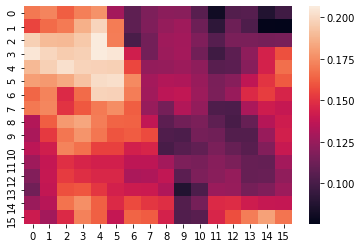

In [14]:

sns.heatmap(train_x[22, 23, :, :, 1])

In [15]:
holdout_for_vis = np.copy(train_x[12, 0, :, :, 10])
for sample in tnrange(0, len(train_x)):
    filtered = median_filter(train_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    train_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
print(train_x.shape)


(31, 24, 16, 16, 16)


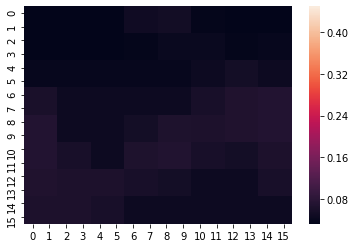

In [16]:
sns.heatmap(train_x[12, 0, :, :, 10], vmax = 0.45)

# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

## Temporal Smoothing

In [17]:

min_all = []
max_all = []


for band in tnrange(0, train_x.shape[-1]):
    mins = np.percentile(train_x[:, :, :, :, band], 1)
    maxs = np.percentile(train_x[:, :, :, :, band], 99)
    #mins = min_all[band]
    #maxs = max_all[band]
    #print(mins1 - mins, maxs1 - maxs)
    train_x[:, :, :, :, band] = np.clip(train_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[:, :, :, :, band] - midrange) / (rng / 2)
    train_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(train_x), np.max(train_x)))
print(min_all, max_all)


The data has been scaled to [-1.0000000000000002, 1.0000000000000002]
[0.033264634368168455, 0.0578297659281701, 0.04094592089560773, 0.17692151507994025, 0.09536655030657168, 0.15204753396281429, 0.17094722934239565, 0.1914782726081256, 0.18414555061648635, 0.09810529944526183, 0.01986273394690619, 0.05280053684286208, 0.08800832204227921, 0.054260039692250836, 0.01763378347447929, 0.0005951018539711605] [0.1564470286465002, 0.22339705422942807, 0.30782785896876264, 0.39095425459179356, 0.3574650450799909, 0.37792678686102144, 0.4056582355957489, 0.42237703311755054, 0.5533367276034993, 0.5103324495456147, 0.17551151911417642, 0.5504685516849501, 0.4454872485852108, 0.4873834305874484, 0.47820416571297764, 0.1207751583123522]


# Normalization of planet data

In [18]:
min_p = []
max_p = []


for band in tnrange(0, train_p.shape[-1]):
    mins = np.percentile(train_p[..., band], 1)
    maxs = np.percentile(train_p[..., band], 99)
    train_p[..., band] = np.clip(train_p[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_p[..., band] - midrange) / (rng / 2)
    train_p[..., band] = standardized
    
    min_p.append(mins)
    max_p.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(train_p), np.max(train_p)))
print(min_p, max_p)


The data has been scaled to [-1.0000000000000002, 1.0]
[219.0, 577.0, 584.0, 2357.43] [1065.0, 1587.0, 2079.0, 3936.0]


# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

## Load and process test data

In [19]:
test_x = np.load("data/test_x.npy")
test_y = np.load("data/test_y.npy")
test_p = np.load("data/test_planet.npy")

test_x = np.delete(test_x, 14, -1)

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
for band in range(0, test_p.shape[-1]):
    mins = min_p[band]
    maxs = max_p[band]
    test_p[..., band] = np.clip(test_p[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_p[..., band] - midrange) / (rng / 2)
    test_p[..., band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)


The data has been scaled to [-1.0000000000000002, 1.0000000000000002]
(9, 24, 16, 16, 16)


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

## Weight cross entropy by effective number of samples

In [20]:
sum_pos = np.sum(train_y)
sum_neg = len(train_y) * 196 - sum_pos
beta = 0.999
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos]) / 196
print(samples_per_cls)
effective_num = 1.0 - np.power(beta, samples_per_cls)
print(effective_num)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
print("Neg and pos weights: {}".format(weights))
weight = weights[1] / weights[0]
print(weight)

Beta: 0.999
[20.2244898 10.7755102]
[0.02003126 0.010723  ]
Neg and pos weights: [0.34866702 0.65133298]
1.8680658935449204


In [21]:
print("Baseline: The positive is: {}".format(weights[0]))
print("Baseline: The negative is: {}".format(weights[1]))
print("\n")
print("Balanced: The positive is: {}".format(weight*weights[0]))
print("Balanced: The negative is: {}".format(weights[1]))


Baseline: The positive is: 0.34866702409127814
Baseline: The negative is: 0.6513329759087217


Balanced: The positive is: 0.6513329759087217
Balanced: The negative is: 0.6513329759087217



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [22]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def calc_mask(seg):

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        #res[np.where(res == 0)] = -1 * loss_importance[196 - sums]
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.logical_and(res < 2, res > 0)] = 0.75
    res[np.logical_or(res >= 2, res <= 0)] = 1.

    
    return res# / max_value

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.03):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return loss
    #return tf.reduce_mean(loss)
'''
    
def calc_dist_map(seg):
    #Utility function for calc_dist_map_batch that calculates the loss
     #  importance per pixel based on the surface distance function
    
    #     Parameters:
     #     seg (arr):
          
     #    Returns:
     #     res (arr):
    #
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        sums = int(np.sum(seg))
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res[np.where(res == 0)] = -1 * loss_importance[196 - sums]
        res[np.where(np.isclose(res, -0.4142, rtol = 1e-2))] = -1 * loss_importance[196 - sums]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = loss_importance[sums]
        res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res# / max_value
'''

def calc_dist_map(seg):
    #Utility function for calc_dist_map_batch that calculates the loss
    #   importance per pixel based on the surface distance function
    
     #    Parameters:
    #      seg (arr):
     #     
    #     Returns:
    #      res (arr):
    #
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance[:20] = 0.
    loss_importance[20:60] = np.arange(0, 40, 1) / 40
    loss_importance[60:] = 1.

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 1.5
                if sums2 <= 1:
                    ones[x - 1, y] = 0.25
                    ones[x + 1, y] = 0.25
                    ones[x, y + 1] = 0.25
                    ones[x, y - 1] = 0.25
                    ones[x - 1, y + 1] = 0.25
                    ones[x + 1, y + 1] = 0.25
                    ones[x + 1, y - 1] = 0.25
                    ones[x -1, y - 1] = 0.25

    if posmask.any():
        
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        #sums = int(np.sum(seg))
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]# * loss_importance[196 - sums]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res# / max_value


def calc_lovasz_weight(y_true):
    if np.sum(y_true) > 12:
        return np.array(1., dtype = np.float32)
    else:
        return np.array(0., dtype = np.float32)
    
def calc_bce_weight(y_true):
    if np.sum(y_true) <= 12:
        return np.array(1., dtype = np.float32)
    else:
        return np.array(0., dtype = np.float32)
    
def calc_lovasz_weight_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    lovasz_batch = np.array([calc_lovasz_weight(y)
                     for y in y_true_numpy]).astype(np.float32)
    return lovasz_batch

def calc_bce_weight_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    bce_batch = np.array([calc_bce_weight(y)
                     for y in y_true_numpy]).astype(np.float32)
    return bce_batch
    
    

def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    #loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    loss = K.mean(multipled)
    return loss

def dice_surf(y_true, y_pred, alpha, weight, batch_size):
    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = 0.03)
    
    def _bce():
        return bce
    
    dices = []
    for x in range(batch_size):
        dice = 1 - dice_loss_tolerance(y_true[x], y_pred[x])
        dices.append(dice)
    dices = tf.reduce_mean(dices)
    surf = surface_loss(y_true, y_pred)
    
    def _surf():
        return ( (1-alpha)*dices + (alpha * surf) )
    
    result = tf.cond(alpha < 0.1, lambda: _bce(), lambda: _surf() )
    return result
    
def bce_surf(y_true, y_pred, alpha, weight, smooth = 0.03, mask = None, ):
    '''Calculates the weighted combination of binary cross entropy and surface loss
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          alpha (float):
          smooth (float):
          weight (float):
          mask (arr):
          
         Returns:
          loss (arr):
    '''

    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = 0.03)
    bce = tf.reduce_mean(bce)
    print("BCE", bce.shape)
    surf = surface_loss(y_true, y_pred)
    print("SURF", surf.shape)
    return ( (1-alpha)*bce + (alpha * surf) )#global_loss #+ regional_loss


def lovasz_surf(y_true, y_pred, alpha, weight, beta):
    
    lv = lovasz_softmax(probas = y_pred,
                        labels = tf.reshape(y_true, (-1, 14, 14)), 
                        classes=[1],
                        per_image=True) 
    print("Lovasz Shape: ", lv.shape)
    
    bce =  weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.03)
    print("BCE Shape: ", bce.shape)
    #return tf.reduce_mean(bce)

    
    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    print("BCE Shape: ", bce.shape)
    surface = surface_loss(y_true, y_pred)
    
    lv_mask = tf.math.reduce_sum(y_true, axis = (1, 2, 3))
    lv_mask = tf.cast(lv_mask, tf.float32)
    lv_mask = tf.math.greater_equal(lv_mask, tf.constant([25.]))
    lv_mask = tf.cast(lv_mask, tf.float32)

    
    bce_mask = tf.math.reduce_sum(y_true, axis = (1, 2, 3))
    bce_mask = tf.cast(bce_mask, tf.float32)
    bce_mask = tf.math.less(bce_mask, tf.constant([25.]))
    bce_mask = tf.cast(bce_mask, tf.float32)
    
    
    lovasz = (lv * lv_mask) + (bce * bce_mask)
    lovasz = tf.reduce_mean(lovasz)
    bce = tf.reduce_mean(bce)
    

    lovasz_portion = (1 - alpha) * lovasz
    lovasz_portion = lovasz_portion * beta
    bce_portion = (1 - alpha) * bce
    bce_portion = bce_portion * (1 - beta)
    surface_portion = alpha * surface
    
    #lovasz_portion = (tf.constant([1.]) - (tf.constant([2.]) * alpha)) * lovasz
    #surface_portion = (tf.constant([2.]) * alpha) * surface
    #non_bce = (alpha) * (lovasz_portion + surface_portion)
    
    result = lovasz_portion + surface_portion + bce_portion
    return result


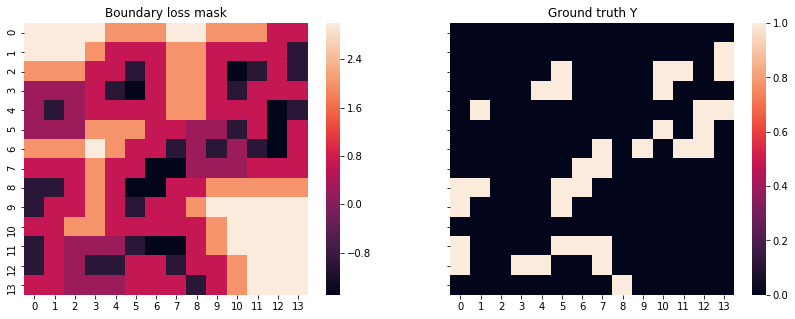

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(14, 5)
sns.heatmap(calc_dist_map(train_y[-3]), ax = ax1)
ax2.set_title('Ground truth Y')
ax1.set_title('Boundary loss mask')
sns.heatmap(train_y[-3], ax = ax2)
plt.show()

# Evaluation metrics

In [24]:
countries = {'africaeast-test': [0, 34],
 'africawest-test': [35, 96],
 'cameroon-test': [97, 135],
 'ethiopia-test': [136, 248],
 'ghana-test': [249, 282],
 'ghana-test-large': [283, 318],
 'global-test': [319, 460],
 'india-test': [461, 511],
 'kenya-test': [512, 600],
 'lac-north-test': [601, 641],
 'lac-south-test': [642, 683], 'all': [0, 683]}

countries = {'all': [0, len(test_y)]}

def dice_loss(y_true, y_pred):
    '''Calculates the dice score of ground truth and prediction arrays
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          metric (arr):
    '''
    numerator = 2 * np.sum(y_true * y_pred, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)

def dice_loss_tolerance(y_true, y_pred):
    numerator_data = np.zeros_like(y_true)
    for x in range(y_true.shape[0]):
        for y in range(y_true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([y_true.shape[0], y+2])
            max_x = np.min([y_true.shape[0], x+2])
            if y_true[x, y] == 1:
                numerator_data[x, y] = np.max(y_pred[min_x:max_x, min_y:max_y])
                
    numerator = 2 * np.sum(y_true * numerator_data, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)
                    
            
        
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    precision =  np.sum(tp) / (np.sum(tp) + np.sum(fp))
    recall = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    f1 = 2 * ((precision * recall) / (precision + recall))
    return np.sum(tp), np.sum(fp), np.sum(fn)

def recover_patches(arr, thresh_p):
    sum1 = np.sum(arr)
    thresh = thresh_p / 2

    for window_x in range(2, arr.shape[0]-2, 1):
        for window_y in range(2, arr.shape[1]-2, 1):
            l, r, u, d =  False, False, False, False
            cur_window = arr[window_x-2:window_x+3, window_y-2:window_y+3]
            hor_vert_neighbors = False
            if (cur_window[2, 2] > thresh and
                cur_window[2, 2] < thresh_p):
                if cur_window[3, 2] > thresh * 2 and cur_window[4, 2] < thresh * 2 :
                    hor_vert_neighbors = True
                    r = True
                if cur_window[1, 2] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                    hor_vert_neighbors = True
                    l = True
                if cur_window[2, 3] > thresh * 2 and cur_window[2, 4] < thresh * 2:
                    hor_vert_neighbors = True
                    d = True
                if cur_window[2, 1] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                    hor_vert_neighbors = True
                    u = True
            passes = False
            if r and not l:
                passes = True
            if l and not r:
                passes = True
            if d and not u:
                passes = True
            if u and not d:
                passes = True

            if passes:
                if r:
                    if cur_window[1, 1] < thresh * 2 and cur_window[1, 3] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)

                if l:
                    if cur_window[3, 1] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)

                if u:
                    if cur_window[1, 3] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)

                if d:
                    if cur_window[1, 1] < thresh * 2 and cur_window[3, 1] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)
    return arr

def calculate_metrics(country, al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    print(canopy_thresh)
    start_idx = countries[country][0]
    stop_idx = countries[country][1]
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    relaxed_f1 = 0
    p = 0
    r = 0
    error = 0
    d = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197) :
            y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                              planet_inp: test_p[test_sample].reshape(1, 32, 32, 4),
                                              length: np.array(24).reshape(1, 1),
                                              is_training: False,
                                              clipping_params['rmax']: rmax_epoch,
                                              clipping_params['rmin']: rmin_epoch,
                                              clipping_params['dmax']: dmax_epoch,
                                              labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                              loss_weight: 2.0,
                                              alpha: al,
                                              })
            ys.append(y.reshape((14, 14)))
            vls.append(vl)
            t = test_y[test_sample].reshape((14, 14))
            t_alls.append(t)
    dice_losses = []
    for thresh in range(8, 13):
        all_preds, all_trues = [], []
        tps, fps, fns = [], [], []
        tps_relaxed, fps_relaxed, fns_relaxed = [], [], []
        abs_error, haus = [], []
        trues, preds = [], []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            if thresh == 8:
                dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
            #pred = recover_patches(pred, thresh*0.05)
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            dists = compute_surface_distances(np.array(true).reshape(14, 14, 1).astype(int),
                                              np.array(pred).reshape(14, 14, 1).astype(int),
                                              [1, 1, 1])
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error.append(abs(pred_s - true_s))
            p_error = np.around(((abs(pred_s - true_s))/196), 3)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed.append(tp_relaxed)
            fps_relaxed.append(fp_relaxed)
            fns_relaxed.append(fn_relaxed)
            trues.append(true_s)
            preds.append(pred_s)
            all_trues.append(true.flatten())
            all_preds.append(pred.flatten())
            if np.sum(true + pred) > 0:
                haus_i = compute_robust_hausdorff(dists, 50)
                if not np.isinf(haus_i):
                    haus.append(haus_i)
            if np.sum(true + pred) == 0:
                dice_losses.append(1.)
                haus.append(0.)
            val_loss.append(np.mean(vl))
        oa_error = np.mean(abs_error)

        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        haus = np.mean(haus)
        dices = np.mean(dice_losses)
        if f1_r > best_f1:
            best_dice = dices
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            to_save_trues = all_trues
            to_save_preds = all_preds
            best_thresh = thresh*0.05
            best_haus = haus
            preds_return = all_preds
            trues_return = all_trues
    print("{}: Val loss: {} Thresh: {} F1: {}"
          " R: {} P: {} D: {} H: {} Error: {}".format(country, 
                                                     np.around(np.mean(val_loss), 3),
                                                     np.around(best_thresh, 2),
                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                     np.mean(best_dice), np.around(best_haus, 3),
                                                     np.around(error, 3)))
    return np.mean(val_loss), best_f1, error, best_haus, np.mean(best_dice)

# Graph set up

In [25]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids, :, :, :]
    y = train_y[batch_ids, :, :]
    planet = train_p[batch_ids, ...]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    planet_batch = np.zeros_like(planet)
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i, ...] = x[i]
            y_batch[i, :, :] = y[i]
            planet_batch[i, ...] = planet[i]
        if current_flip == 1:
            x_batch[i, :, :, :] = np.flip(x[i], 1)
            y_batch[i, :, :] = np.flip(y[i], 0)
            planet_batch[i, ...] = np.flip(planet[i], 0)
        if current_flip == 2:
            x_batch[i, :, :, :] = np.flip(x[i], [2, 1])
            y_batch[i, :, :] = np.flip(y[i], [1, 0])
            planet_batch[i, ...] = np.flip(planet[i], [1, 0])
        if current_flip == 3:
            x_batch[i, :, :, :] = np.flip(x[i], 2)
            y_batch[i, :, :] = np.flip(y[i], 1)
            planet_batch[i, ...] = np.flip(planet[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    return x_batch, y_batch, planet_batch

x_batch_test, y_batch_test, planet_batch = augment_batch([0, 1], 2)
train_ids = [x for x in range(0, len(test_y))]

In [26]:
FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 100
LEARNING_RATE = 3e-3
test_ids = [x for x in range(0, len(test_x))]

print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))
        
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), len(train_ids)/4))

    optimizer = AdaBoundOptimizer(1e-4, 1e-2)
    #optimizer = tf.train.AdamOptimizer(1e-4)
    train_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = loss_weight, alpha = alpha, beta = beta_)
    #train_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, 
    #                      smooth = 0.03, 
    #                      weight = loss_weight,
    #                      alpha = alpha)
    #l2_loss = tf.losses.get_regularization_l05oss()
    #train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(ft_lr)
    test_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = loss_weight, alpha = alpha, beta = beta_)
    ##test_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm,
    #                     weight = loss_weight, 
    #                     smooth = 0.03, 
    #                     alpha = alpha)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 125)
    
print("The graph has been finalized")

Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0001 initial LR 
 0.02 final LR 
 443768 parameters
Restarting training from scratch on 9 train and 9 test samples, total 2.25
(?,)
Lovasz Shape:  (?,)
BCE Shape:  (?, 14, 14, 1)
BCE Shape:  (?,)
(?,)
Lovasz Shape:  (?,)
BCE Shape:  (?, 14, 14, 1)
BCE Shape:  (?,)
The graph has been finalized


In [27]:
train_losses = []
test_losses = []
f1s = []
dices = []
errors = []
hausdorff = []

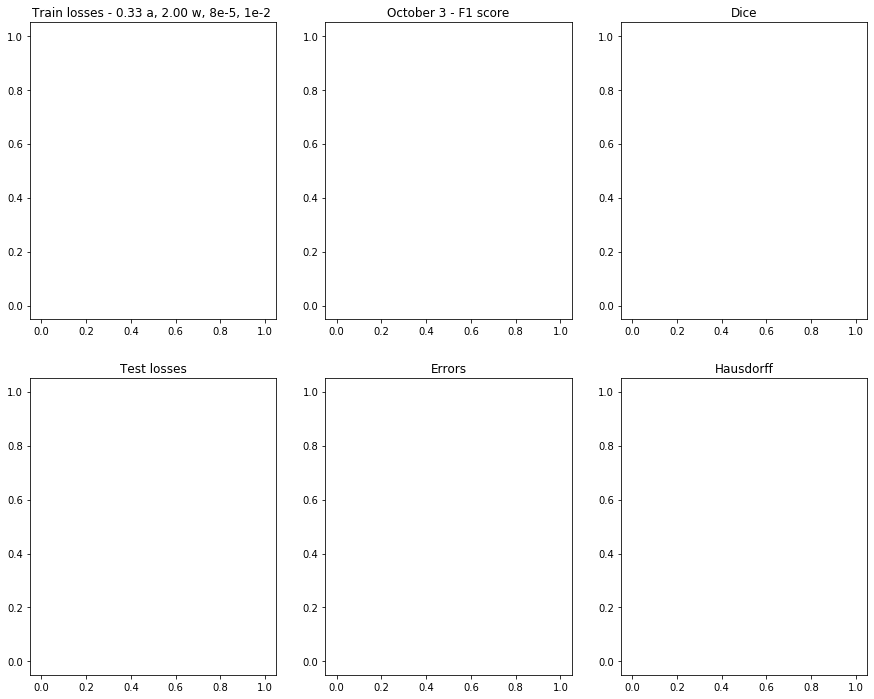

In [28]:
f, ((c1r1, c1r2, c1r3), (c2r1, c2r2, c2r3)) = plt.subplots(2, 3, sharey=False)
f.set_size_inches(15, 12)

c1r1.set_title("Train losses - 0.33 a, 2.00 w, 8e-5, 1e-2 ")
sns.scatterplot(y = np.array(train_losses[:]),
                x = np.array([x for x in range(len(train_losses[:]))]),
               ax = c1r1)

c1r2.set_title("October 3 - F1 score")
sns.scatterplot(y = np.array(f1s[:]),
                x = np.array([x for x in range(len(f1s[:]))]),
               ax = c1r2)

c2r1.set_title("Test losses")
sns.scatterplot(y = np.array(test_losses[:]),
                x = np.array([x for x in range(len(test_losses[:]))]),
               ax = c2r1)

c2r2.set_title("Errors")
sns.scatterplot(y = np.array(errors[:]),
                x = np.array([x for x in range(len(errors[:]))]),
               ax = c2r2)

c2r3.set_title("Hausdorff")
sns.scatterplot(y = np.array(hausdorff[:]),
                x = np.array([x for x in range(len(errors[:]))]),
               ax = c2r3)

c1r3.set_title("Dice")
sns.scatterplot(y = np.array(dices[:]),
                x = np.array([x for x in range(len(dices[:]))]),
               ax = c1r3)

plt.show()

# September changes
- Implement equibatch
- Implement 4x4 FPA, with CSSE in middle blocks
- Reduce label smoothing from 0.08 to 0.03
- reduce dropblock to 0.95 from 0.8

# Things to test
- Concatenating mean after GRU
- Turning of sse in GRU

In [29]:
train_ids = [x for x in range(0, len(train_y))]

In [30]:
### import scipy
best_val = 0.5
fine_tune = False
countries['all'] = [0, len(test_x)]
ft_epochs = 0
ft_learning_rate = 1e-2

ft_e = 0

for i in range(0, 50):
    ft_e += 1
    #al = 0.33
    al = np.min( [0.01 * (i - 1), 0.33] )
    #else:
    be = 0.0
    #al = 1.0
    if al < 0.8:
        test_al = 0.33
    else:
        test_al = al
    if fine_tune == True:
        op = ft_op
        ft_epochs += 1
        if ft_epochs % 40 == 0:
            ft_learning_rate /= 2
            
            print("DIVIDING LR")
        print("FINE TUNING WITH {} LR".format(ft_learning_rate))
        
    else:
        op = op = train_op
    #randomize = equibatch(train_ids)
    randomize = train_ids
    print("starting epoch {}, alpha: {}, beta: {} drop: {}".format(i, al, be, np.max((1. - (i*0.0075), 0.80))))
    
    loss = train_loss
    BATCH_SIZE = 4
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        rmax_epoch, dmax_epoch, rmin_epoch = calc_renorm_params(i, 50, 4, k)
        if k % 8 == 0:
            sleep(1)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch, p_batch = augment_batch(batch_ids, BATCH_SIZE)
        opt, tr = sess.run([op, loss],
                          feed_dict={inp: x_batch,
                                     length: np.full((BATCH_SIZE, 1), 24),
                                     planet_inp: p_batch,
                                     labels: y_batch,
                                     is_training: True,
                                     clipping_params['rmax']: rmax_epoch,
                                     clipping_params['rmin']: rmin_epoch,
                                     clipping_params['dmax']: dmax_epoch,
                                     loss_weight: 2.0, # global: 2.0, LAC: 1.75
                                     #loss_weight: np.max([1.9 - (i * 0.015), 1.3]), 
                                     keep_rate: np.max((1. - (i * 0.0075), 0.75)),
                                     alpha: al,
                                     beta_: be,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    
    val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 100)
    train_losses.append(np.mean(losses[:-1]))
    test_losses.append(val_loss)
    f1s.append(f1)
    dices.append(dice)
    errors.append(error)
    hausdorff.append(haus)
    #if f1 > (best_val - 0.02):
    #    print("Saving model with {}".format(dice))
    #    os.mkdir("../models/eastafrica/{}-{}-{}/".format(str(i), str(f1*100)[:2], str(f1*100)[3]))
    #    save_path = saver.save(sess, "../models/eastafrica/{}-{}-{}/model".format(str(i), str(f1*100)[:2], str(f1*100)[3]))
    #    if f1 > best_val:
    ##        best_val = f1
    

starting epoch 0, alpha: -0.01, beta: 0.0 drop: 1.0



Epoch 0: Loss 1.3680000305175781
100


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


all: Val loss: 0.7390000224113464 Thresh: 0.4 F1: 0.579 R: 0.959 P: 0.414 D: 0.4394340033299034 H: 0.971 Error: 42.889
starting epoch 1, alpha: 0.0, beta: 0.0 drop: 0.9925



Epoch 1: Loss 1.0720000267028809
100
all: Val loss: 0.6140000224113464 Thresh: 0.4 F1: 0.79 R: 0.794 P: 0.786 D: 0.5128894994789206 H: 2.037 Error: 38.889
starting epoch 2, alpha: 0.01, beta: 0.0 drop: 0.985



Epoch 2: Loss 1.0219999551773071
100
all: Val loss: 0.5809999704360962 Thresh: 0.45 F1: 0.819 R: 0.782 P: 0.859 D: 0.5516166009606505 H: 1.387 Error: 45.444
starting epoch 3, alpha: 0.02, beta: 0.0 drop: 0.9775



Epoch 3: Loss 0.9670000076293945
100
all: Val loss: 0.5820000171661377 Thresh: 0.6 F1: 0.83 R: 0.812 P: 0.85 D: 0.5659105830805637 H: 1.335 Error: 38.778
starting epoch 4, alpha: 0.03, beta: 0.0 drop: 0.97



Epoch 4: Loss 0.9259999990463257
100
all: Val loss: 0.5879999995231628 Thresh: 0.6 F1: 0.834 R: 0.799 P: 0.872 D: 0.5671440677480085 H: 1.178 Error: 39.111
starting epoch 5, alpha: 0.04, beta: 0.0 drop: 0.9625



Epoch 5: Loss 0.875
100
all: Val loss: 0.5920000076293945 Thresh: 0.6 F1: 0.851 R: 0.798 P: 0.912 D: 0.5653627253620068 H: 0.556 Error: 43.222
starting epoch 6, alpha: 0.05, beta: 0.0 drop: 0.955



Epoch 6: Loss 0.8489999771118164
100
all: Val loss: 0.597000002861023 Thresh: 0.6 F1: 0.85 R: 0.795 P: 0.914 D: 0.5634304622028397 H: 0.556 Error: 46.222
starting epoch 7, alpha: 0.06, beta: 0.0 drop: 0.9475



Epoch 7: Loss 0.8199999928474426
100
all: Val loss: 0.5979999899864197 Thresh: 0.6 F1: 0.855 R: 0.801 P: 0.917 D: 0.5627475102295836 H: 0.444 Error: 46.667
starting epoch 8, alpha: 0.07, beta: 0.0 drop: 0.94



Epoch 8: Loss 0.7760000228881836
100
all: Val loss: 0.597000002861023 Thresh: 0.6 F1: 0.858 R: 0.812 P: 0.91 D: 0.5626221846838205 H: 0.49 Error: 45.333
starting epoch 9, alpha: 0.08, beta: 0.0 drop: 0.9325



Epoch 9: Loss 0.765999972820282
100
all: Val loss: 0.6029999852180481 Thresh: 0.6 F1: 0.848 R: 0.802 P: 0.899 D: 0.5602668900252064 H: 0.765 Error: 46.556
starting epoch 10, alpha: 0.09, beta: 0.0 drop: 0.925



Epoch 10: Loss 0.7310000061988831
100
all: Val loss: 0.609000027179718 Thresh: 0.55 F1: 0.841 R: 0.767 P: 0.931 D: 0.5591743429450909 H: 0.444 Error: 54.333
starting epoch 11, alpha: 0.1, beta: 0.0 drop: 0.9175



Epoch 11: Loss 0.7110000252723694
100
all: Val loss: 0.5920000076293945 Thresh: 0.55 F1: 0.854 R: 0.796 P: 0.92 D: 0.5645427531994124 H: 0.444 Error: 49.333
starting epoch 12, alpha: 0.11, beta: 0.0 drop: 0.91



Epoch 12: Loss 0.6899999976158142
100
all: Val loss: 0.5849999785423279 Thresh: 0.55 F1: 0.857 R: 0.806 P: 0.914 D: 0.566573508292573 H: 0.49 Error: 48.556
starting epoch 13, alpha: 0.12, beta: 0.0 drop: 0.9025



Epoch 13: Loss 0.671999990940094
100
all: Val loss: 0.5929999947547913 Thresh: 0.6 F1: 0.85 R: 0.815 P: 0.888 D: 0.5637399482571706 H: 0.856 Error: 46.667
starting epoch 14, alpha: 0.13, beta: 0.0 drop: 0.895



Epoch 14: Loss 0.6439999938011169
100
all: Val loss: 0.593999981880188 Thresh: 0.55 F1: 0.854 R: 0.791 P: 0.928 D: 0.5633743645775067 H: 0.333 Error: 51.667
starting epoch 15, alpha: 0.14, beta: 0.0 drop: 0.8875



Epoch 15: Loss 0.6299999952316284
100
all: Val loss: 0.5870000123977661 Thresh: 0.6 F1: 0.86 R: 0.829 P: 0.893 D: 0.5659414841757916 H: 0.707 Error: 44.444
starting epoch 16, alpha: 0.15, beta: 0.0 drop: 0.88



Epoch 16: Loss 0.6019999980926514
100
all: Val loss: 0.578000009059906 Thresh: 0.6 F1: 0.872 R: 0.845 P: 0.901 D: 0.5700212775044184 H: 0.425 Error: 40.0
starting epoch 17, alpha: 0.16, beta: 0.0 drop: 0.8725



Epoch 17: Loss 0.5979999899864197
100
all: Val loss: 0.5830000042915344 Thresh: 0.6 F1: 0.874 R: 0.844 P: 0.907 D: 0.5710856325850086 H: 0.425 Error: 40.556
starting epoch 18, alpha: 0.17, beta: 0.0 drop: 0.865



Epoch 18: Loss 0.5680000185966492
100
all: Val loss: 0.5889999866485596 Thresh: 0.6 F1: 0.872 R: 0.839 P: 0.907 D: 0.5725133592989042 H: 0.36 Error: 40.111
starting epoch 19, alpha: 0.18, beta: 0.0 drop: 0.8575



Epoch 19: Loss 0.5569999814033508
100
all: Val loss: 0.6000000238418579 Thresh: 0.6 F1: 0.861 R: 0.817 P: 0.909 D: 0.5726925825132856 H: 0.444 Error: 41.556
starting epoch 20, alpha: 0.19, beta: 0.0 drop: 0.85



Epoch 20: Loss 0.531000018119812
100
all: Val loss: 0.640999972820282 Thresh: 0.6 F1: 0.844 R: 0.769 P: 0.936 D: 0.5660487057124469 H: 0.333 Error: 52.0
starting epoch 21, alpha: 0.2, beta: 0.0 drop: 0.8425



Epoch 21: Loss 0.5199999809265137
100
all: Val loss: 0.6349999904632568 Thresh: 0.6 F1: 0.851 R: 0.789 P: 0.925 D: 0.5685192296509538 H: 0.333 Error: 49.111
starting epoch 22, alpha: 0.21, beta: 0.0 drop: 0.835



Epoch 22: Loss 0.5040000081062317
100
all: Val loss: 0.6340000033378601 Thresh: 0.6 F1: 0.849 R: 0.79 P: 0.917 D: 0.5696480408362579 H: 0.444 Error: 47.333
starting epoch 23, alpha: 0.22, beta: 0.0 drop: 0.8275



Epoch 23: Loss 0.48500001430511475
100
all: Val loss: 0.6790000200271606 Thresh: 0.55 F1: 0.826 R: 0.725 P: 0.96 D: 0.5634860933064585 H: 0.333 Error: 62.778
starting epoch 24, alpha: 0.23, beta: 0.0 drop: 0.8200000000000001



Epoch 24: Loss 0.47600001096725464
100
all: Val loss: 0.6610000133514404 Thresh: 0.55 F1: 0.83 R: 0.742 P: 0.942 D: 0.567843562302054 H: 0.333 Error: 57.556
starting epoch 25, alpha: 0.24, beta: 0.0 drop: 0.8125



Epoch 25: Loss 0.46000000834465027
100
all: Val loss: 0.6650000214576721 Thresh: 0.6 F1: 0.827 R: 0.761 P: 0.906 D: 0.5688989523310198 H: 0.719 Error: 53.111
starting epoch 26, alpha: 0.25, beta: 0.0 drop: 0.8049999999999999



Epoch 26: Loss 0.4390000104904175
100
all: Val loss: 0.7110000252723694 Thresh: 0.6 F1: 0.819 R: 0.728 P: 0.936 D: 0.5624767347732615 H: 0.471 Error: 61.778
starting epoch 27, alpha: 0.26, beta: 0.0 drop: 0.8



Epoch 27: Loss 0.421999990940094
100
all: Val loss: 0.6610000133514404 Thresh: 0.6 F1: 0.834 R: 0.768 P: 0.912 D: 0.5700829803730094 H: 0.471 Error: 51.111
starting epoch 28, alpha: 0.27, beta: 0.0 drop: 0.8



Epoch 28: Loss 0.4090000092983246
100
all: Val loss: 0.7120000123977661 Thresh: 0.6 F1: 0.82 R: 0.733 P: 0.931 D: 0.563419112073511 H: 0.574 Error: 61.333
starting epoch 29, alpha: 0.28, beta: 0.0 drop: 0.8



Epoch 29: Loss 0.39100000262260437
100
all: Val loss: 0.7289999723434448 Thresh: 0.6 F1: 0.816 R: 0.723 P: 0.938 D: 0.5627071360698764 H: 0.471 Error: 63.111
starting epoch 30, alpha: 0.29, beta: 0.0 drop: 0.8



Epoch 30: Loss 0.38499999046325684
100
all: Val loss: 0.7160000205039978 Thresh: 0.6 F1: 0.819 R: 0.73 P: 0.931 D: 0.5653646374600284 H: 0.471 Error: 60.111
starting epoch 31, alpha: 0.3, beta: 0.0 drop: 0.8



Epoch 31: Loss 0.37700000405311584
100
all: Val loss: 0.7760000228881836 Thresh: 0.55 F1: 0.799 R: 0.688 P: 0.952 D: 0.5601398663688019 H: 0.333 Error: 71.444
starting epoch 32, alpha: 0.31, beta: 0.0 drop: 0.8



Epoch 32: Loss 0.3569999933242798
100
all: Val loss: 0.7649999856948853 Thresh: 0.6 F1: 0.806 R: 0.706 P: 0.939 D: 0.5623756200876207 H: 0.536 Error: 67.778
starting epoch 33, alpha: 0.32, beta: 0.0 drop: 0.8



Epoch 33: Loss 0.34200000762939453
100
all: Val loss: 0.8220000267028809 Thresh: 0.6 F1: 0.794 R: 0.69 P: 0.936 D: 0.5598220710493441 H: 0.574 Error: 71.667
starting epoch 34, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 34: Loss 0.3310000002384186
100
all: Val loss: 0.8479999899864197 Thresh: 0.55 F1: 0.789 R: 0.675 P: 0.949 D: 0.5595083689450446 H: 0.379 Error: 75.0
starting epoch 35, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 35: Loss 0.32899999618530273
100
all: Val loss: 0.8230000138282776 Thresh: 0.5 F1: 0.791 R: 0.678 P: 0.949 D: 0.5624964252513786 H: 0.379 Error: 74.333
starting epoch 36, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 36: Loss 0.3240000009536743
100
all: Val loss: 0.7960000038146973 Thresh: 0.4 F1: 0.795 R: 0.676 P: 0.966 D: 0.5657660656207003 H: 0.222 Error: 75.556
starting epoch 37, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 37: Loss 0.3269999921321869
100
all: Val loss: 0.7820000052452087 Thresh: 0.6 F1: 0.799 R: 0.714 P: 0.907 D: 0.5665798135553454 H: 0.968 Error: 65.0
starting epoch 38, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 38: Loss 0.3100000023841858
100
all: Val loss: 0.7570000290870667 Thresh: 0.55 F1: 0.801 R: 0.709 P: 0.92 D: 0.5700750922664979 H: 0.574 Error: 65.556
starting epoch 39, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 39: Loss 0.31200000643730164
100
all: Val loss: 0.8109999895095825 Thresh: 0.6 F1: 0.801 R: 0.703 P: 0.93 D: 0.5634240405962053 H: 0.68 Error: 68.667
starting epoch 40, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 40: Loss 0.3109999895095825
100
all: Val loss: 0.7450000047683716 Thresh: 0.6 F1: 0.808 R: 0.723 P: 0.917 D: 0.5687892661855671 H: 0.694 Error: 62.778
starting epoch 41, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 41: Loss 0.3089999854564667
100
all: Val loss: 0.8550000190734863 Thresh: 0.6 F1: 0.789 R: 0.686 P: 0.93 D: 0.5608966199390659 H: 0.694 Error: 73.111
starting epoch 42, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 42: Loss 0.3019999861717224
100
all: Val loss: 0.7559999823570251 Thresh: 0.55 F1: 0.806 R: 0.712 P: 0.93 D: 0.5743560372591139 H: 0.574 Error: 65.556
starting epoch 43, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 43: Loss 0.3070000112056732
100
all: Val loss: 0.7540000081062317 Thresh: 0.6 F1: 0.813 R: 0.722 P: 0.93 D: 0.5711929246336502 H: 0.471 Error: 64.333
starting epoch 44, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 44: Loss 0.30300000309944153
100
all: Val loss: 0.8930000066757202 Thresh: 0.6 F1: 0.79 R: 0.685 P: 0.933 D: 0.561379028913685 H: 0.623 Error: 74.222
starting epoch 45, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 45: Loss 0.3050000071525574
100
all: Val loss: 0.7889999747276306 Thresh: 0.55 F1: 0.806 R: 0.701 P: 0.949 D: 0.5720853533385154 H: 0.379 Error: 68.667
starting epoch 46, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 46: Loss 0.2980000078678131
100
all: Val loss: 0.7549999952316284 Thresh: 0.6 F1: 0.81 R: 0.727 P: 0.915 D: 0.5755612607269791 H: 0.667 Error: 62.111
starting epoch 47, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 47: Loss 0.289000004529953
100
all: Val loss: 0.7570000290870667 Thresh: 0.6 F1: 0.809 R: 0.726 P: 0.914 D: 0.5773234506801382 H: 0.694 Error: 62.333
starting epoch 48, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 48: Loss 0.28600001335144043
100
all: Val loss: 0.7400000095367432 Thresh: 0.55 F1: 0.816 R: 0.733 P: 0.922 D: 0.5833577417030105 H: 0.471 Error: 59.333
starting epoch 49, alpha: 0.33, beta: 0.0 drop: 0.8



Epoch 49: Loss 0.289000004529953
100
all: Val loss: 0.8230000138282776 Thresh: 0.6 F1: 0.801 R: 0.713 P: 0.914 D: 0.5740217383624909 H: 0.925 Error: 66.444


# Model validation and sanity checks





# Prediction visualizations

In [31]:
start = 0

test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show



In [32]:
def identify_alignment(true, pred, wsize = 3, difference = 0.2):
    '''Docstring
    
         Parameters:
          true (arr):
          pred (arr):
          wsize (int):
          difference (float):
          
         Returns:
          None
    '''
    n_single_trees = 0
    for x in range(1, true.shape[0] - 1, 1):
        for y in range(1, true.shape[1] - 1, 1):
            wind_true = true[x-1:x+2, y-1:y+2]
            wind_pred = pred[x-1:x+2, y-1:y+2]
            if wind_true[1, 1] == 1:
                if np.sum(wind_true) == 1:
                    n_single_trees += 1
                    pred_place = np.argmax(wind_pred.flatten())
                    diff = wind_pred.flatten()[pred_place] - wind_pred.flatten()[4]
                    if pred_place != 4:
                        if diff > difference:
                            x_lv = pred_place // 3
                            y_lv = pred_place % 3
                            print(x_lv, y_lv)
                            proposed = wind_true[x_lv - 1:x_lv+2, y_lv-1:y_lv+2]
                            if np.sum(proposed) == 0:
                                print("There is a missed position at {} x, {} y: {}".format(x, y, diff))

0.0
[0, 1, 2, 3, 4, 5, 6, 7]
0.5223244930462694 0.5587909995164005
0.806827358458361 0.8331892127859838
0.33770355265136226 0.3825032996423983
0.6391401395039756 0.6444714866420982
0.423981659479823 0.522229595809697
0.3034175459954933 0.3180440004992898
0.5194892612644858 0.6564065170258849
0.42594465151394517 0.4583143904964509


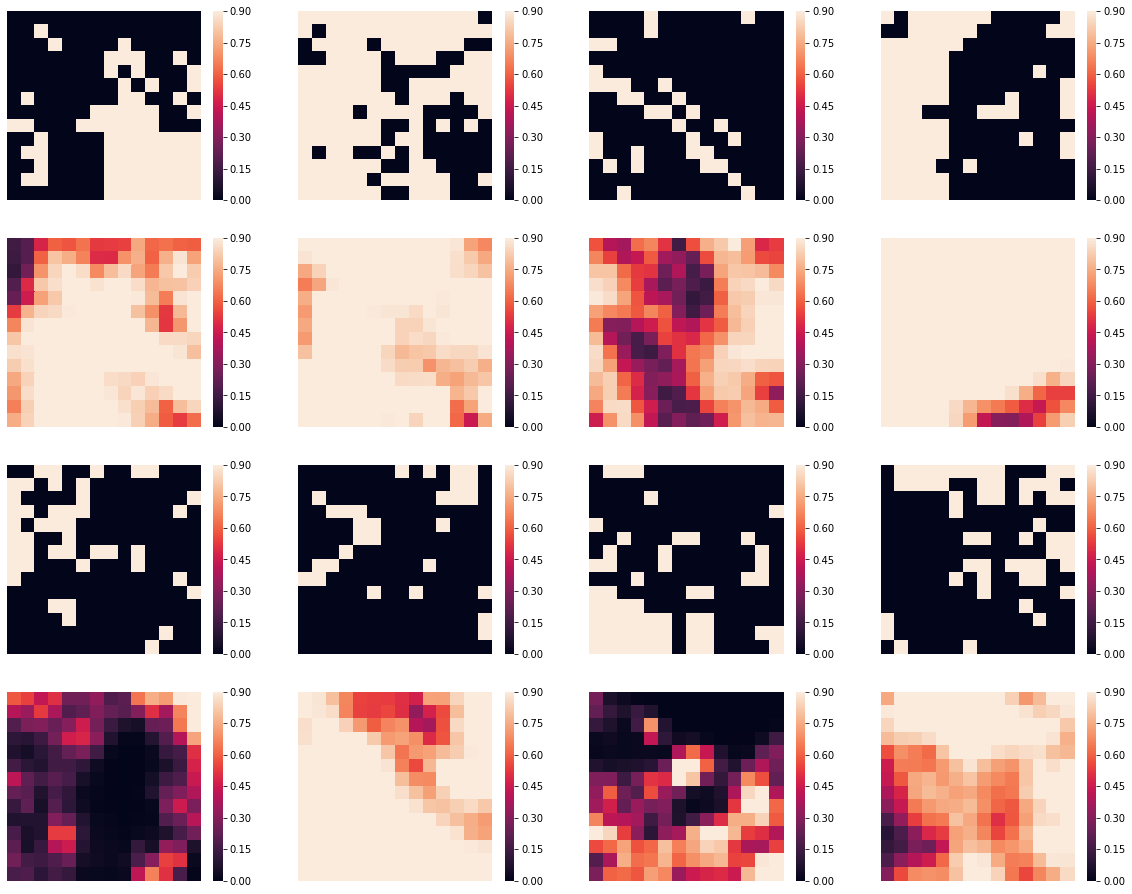

In [33]:
from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = sorted(test_ids)

start = 0
to_test = [681, 684, 689, 732, 791, 798, 802, 877, 905, 947, 951, 964, 965, 966, 997, 1094, 1101]
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = np.argwhere(abs(np.array(diffs)) > 100)[8 + 8 + 8 + 8 : 8 + 8 + 8 + 8 + 8]

preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    #print(plot_ids_loaded[i])
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: np.full((1, 1), 24),
                                  planet_inp: test_p[idx].reshape(1, 32, 32, 4),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    #y, mapshape = aggregate_maxes(test_y[idx], y)
    preds.append(y)
    y2 = np.copy(y)
    print(np.mean(dice_loss(test_y[idx], y)), np.mean(dice_loss_tolerance(test_y[idx], y)))
    #surf_distances = 
    #y[np.where(y > 0.4)] = 1.0
    #y[np.where(y < 0.4)] = 0.
    #y[np.where(y >= 0.4)] = 1.
    #dc = np.around(dice_loss(test_y[idx].flatten(), y2.flatten()), 3)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)


start = start + 8 


# 220, ""

In [36]:
train_ids = [x for x in range(train_x.shape[0])]
train_ids = sorted(train_ids)
start = 22



[22, 23, 24, 25, 26, 27, 28, 29]


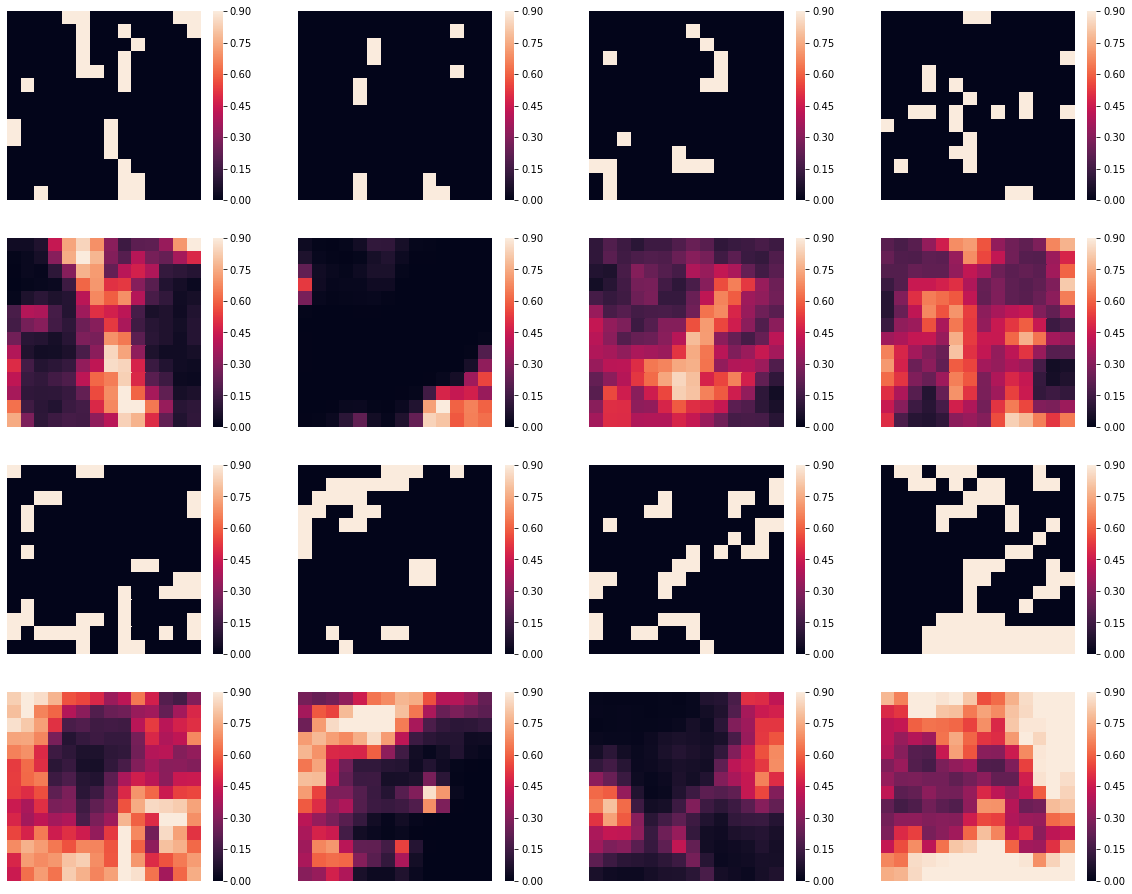

In [37]:
##matrix_ids = [70, 139, 456, 630, 718, 800, 835, 1101]
#matrix_ids = np.argwhere(abs(np.array(diffs)) > 20)[8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8:
#                                                    8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8]

matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2],
             train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7]]
#matrix_ids = [358, 425, 459, 516, 625, 705, 1065]
preds = []
trues = []
#print(start//4)
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: np.full((1, 1), 24),
                                  planet_inp: train_p[idx].reshape(1, 32, 32, 4),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                    })
    y = np.array(y).reshape(14, 14)
    
    #y, _ = aggregate_maxes(train_y[idx], y)
    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    #print(np.mean(dice_loss(train_y[idx], y)), np.mean(dice_loss_tolerance(train_y[idx], y)))
    #identify_alignment(true, y)
    
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)